### LibESN - Multi-Frequency ESN test notebook

##### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.path.abspath(""), "../../"))

In [3]:
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN
from LibESN.mfesn import MFESN
from LibESN.mfesn_fit import mfRidgeFit

In [4]:
### AR(1) data
def ar(length, alpha, sigma, seed=123456):
    rng = np.random.default_rng(seed)
    eps = rng.standard_normal(size=(length))
    Y = np.zeros((length))
    Y[0] = eps[0]
    for t in range(1, length):
        Y[t] = alpha*Y[t-1] + sigma*eps[t]
    return Y 

# Multi-frequency data set
years = 50
Y_m = ar(12*years + 3, 0.7, 0.5, seed=399)
Y_q = ar(4*years + 1, 0.9, 0.5, seed=103)
eps = np.random.default_rng(852).standard_normal(size=4*years)
Y   = np.zeros(4*years)
Y_n = np.zeros(4*years)
Y_n[0] = 1.1*Y_m[2] + 0.7*Y_m[1] + 0.2*Y_m[0] - 0.3*Y_q[0] 
Y[0] = Y_n[0] + 0.7*eps[0]
for t in range(1, 4*years):
    Y_n[t] = 1.1*Y_m[2+t] + 0.7*Y_m[t+1] + 0.2*Y_m[t] - 0.3*Y_q[t] 
    Y[t] = Y_n[t] + 0.7*eps[t]
Y_m = Y_m[3:]
Y_q = Y_q[1:]

Y_m0 = pd.DataFrame(data=Y_m, 
            index=pd.date_range('1970-01-01', str(1970+years)+'-01-01', freq='M'))
Y_q0 = pd.DataFrame(data=Y_q,
            index=pd.date_range('1970-01-01', str(1970+years)+'-01-01', freq='Q'))
Y_0 = pd.DataFrame(data=Y,
            index=pd.date_range('1970-01-01', str(1970+years)+'-01-01', freq='Q'))
Y_n0 = pd.DataFrame(data=Y_n,
            index=pd.date_range('1970-01-01', str(1970+years)+'-01-01', freq='Q'))

mfdata_train = (
    [Y_m0.loc[:"2010-12-31"], Y_q0.loc[:"2010-12-31"]], 
    Y_0.loc[:"2010-12-31"]
)
mfdata_test = (
    [Y_m0.loc["2011-01-01":], Y_q0.loc["2011-01-01":]], 
    Y_0.loc["2011-01-01":]
)

mfdata_nonoise_train = Y_n0.loc[:"2010-12-31"]
mfdata_nonoise_test = Y_n0.loc["2011-01-01":]

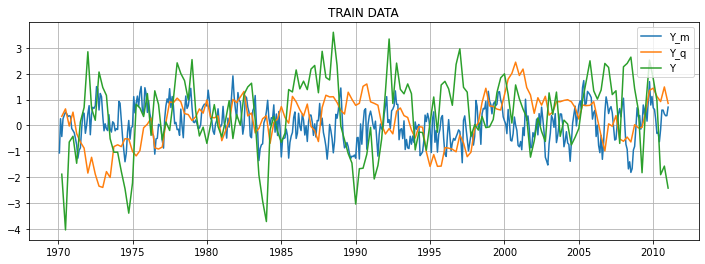

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(mfdata_train[0][0], label='Y_m') 
plt.plot(mfdata_train[0][1], label='Y_q')  
plt.plot(mfdata_train[1], label='Y')  
plt.grid()
plt.legend()
plt.title("TRAIN DATA")
plt.show()

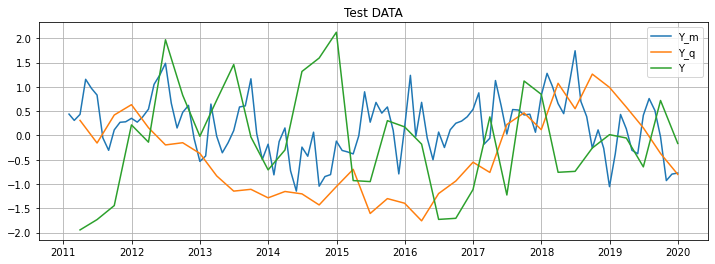

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(mfdata_test[0][0], label='Y_m') 
plt.plot(mfdata_test[0][1], label='Y_q')  
plt.plot(mfdata_test[1], label='Y')  
plt.grid()
plt.legend()
plt.title("Test DATA")
plt.show()

MFESN definition:

In [7]:
A = matrixGenerator((50, 50), dist='sparse_uniform', sparsity=0.2, seed=123)
C = matrixGenerator((50, 1), dist='sparse_uniform', sparsity=0.2, seed=12345)
zeta = 0.0 * matrixGenerator((50, ), seed=123456)
rho = 0.9
gamma = 1
leak = 0.0

esn_m = ESN(
    None,
    smap=np.tanh, 
    A=A, C=C, zeta=zeta, 
    rho=rho, gamma=gamma, leak=leak
)

A = matrixGenerator((30, 30), dist='sparse_uniform', sparsity=0.2, seed=890)
C = matrixGenerator((30, 1), dist='sparse_uniform', sparsity=0.2, seed=7890)
zeta = 0.0 * matrixGenerator((30, ), seed=567890)
rho = 0.9
gamma = 1
leak = 0.1

esn_q = ESN(
    None,
    smap=np.tanh, 
    A=A, C=C, zeta=zeta, 
    rho=rho, gamma=gamma, leak=leak
)

In [8]:
mfesn = MFESN((esn_m, esn_q))
mfesn.print()

        MFESN:  Component ESN #1         
                                         
  Parameter    Shape         Value       
 ─────────────────────────────────────── 
  smap           -       <ufunc 'tanh'>  
  A           (50, 50)         -         
  C           (50, 1)          -         
  zeta         (50,)           -         
  rho          scalar         0.9        
  gamma        scalar          1         
  leak         scalar         0.0

        MFESN:  Component ESN #2         
                                         
  Parameter    Shape         Value       
 ─────────────────────────────────────── 
  smap           -       <ufunc 'tanh'>  
  A           (30, 30)         -         
  C           (30, 1)          -         
  zeta         (30,)           -         
  rho          scalar         0.9        
  gamma        scalar          1         
  leak         scalar         0.1

##### One-step fit

In [9]:
from LibESN.mfesn_fit import mfRidgeCV

ridgecv = mfRidgeCV()

ridgecv.cv(
    mfmodel=mfesn,
    train_data=mfdata_train,
    step=1,
    min_train_size=10,
    test_size=1,
    verbose=True,
)

{'model': 'MFESN',
 'method': 'mfRidgeFit.cv',
 'cvLambda': array([0.88309196, 0.12910535]),
 'result':       fun: 265.2187395742614
  hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
       jac: array([-3.41060511e-05, -4.54747351e-05])
   message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      nfev: 111
       nit: 13
      njev: 37
    status: 0
   success: True
         x: array([0.88309196, 0.12910535]),
 'optim': 'scipy',
 'init': None,
 'burnin': [0, 0]}

In [10]:
fit = mfesn.fit(mfdata_train, mfRidgeFit([0.8, 0.1]))

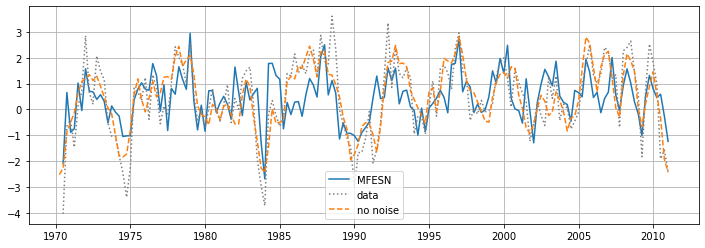

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(fit['mf_Y_fit'], label="MFESN")
plt.plot(fit['mf_Y'], color='C7', linestyle='dotted', label="data")
plt.plot(mfdata_nonoise_train, linestyle='dashed', label="no noise")  
plt.grid()
plt.legend()
plt.show()

Forecast:

In [12]:
from LibESN.mfesn_forecast import mfForecast

In [13]:
forecast = mfForecast(
    mfmodel=mfesn,
    forecast_data=mfdata_test[0],
    fit=fit,
)

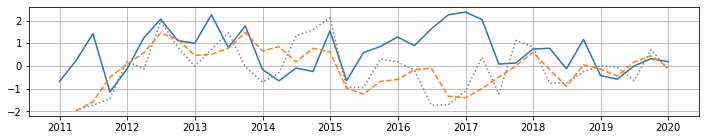

In [14]:
plt.figure(figsize=(12, 2))
plt.plot(forecast['forecast'], label=('nowcast'))
plt.plot(mfdata_test[1], color='C7', linestyle='dotted', label='data')
plt.plot(mfdata_nonoise_test, linestyle='dashed', label="no noise")  
plt.grid()
plt.show()

##### Multi-step iterative fit

In [15]:
msfit = mfesn.fitMultistep(mfdata_train, mfRidgeFit(0.0), steps=5)

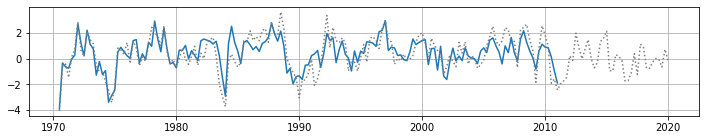

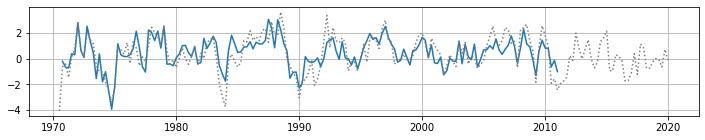

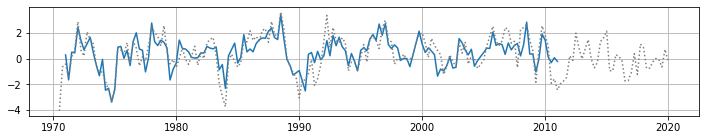

In [16]:
for i in range(3):
    plt.figure(figsize=(12, 2))
    plt.plot(msfit['fits'][i]['mf_Y_fit'][0], label=('A_fit('+str(i)+')'))
    #plt.plot(data_fit_best, linestyle='dashed')  
    plt.plot(Y_0[1:], color='C7', linestyle='dotted')
    plt.grid()
    plt.show()

##### Multi-step direct fit

In [17]:
dmsfit = mfesn.fitDirectMultistep(mfdata_train, mfRidgeFit(0.0), steps=5)

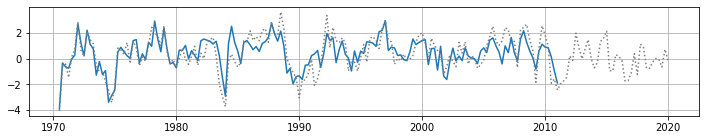

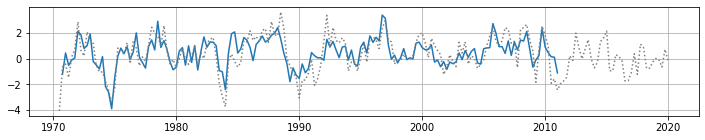

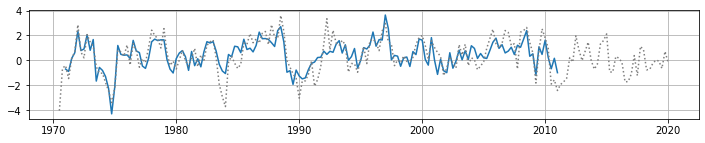

In [18]:
for i in range(3):
    plt.figure(figsize=(12, 2))
    plt.plot(dmsfit['fits'][i]['mf_Y_fit'][0], label=('A_fit('+str(i)+')'))
    #plt.plot(data_fit_best, linestyle='dashed')  
    plt.plot(Y_0[1:], color='C7', linestyle='dotted')
    plt.grid()
    plt.show()

##### Nowcasting fit

In [19]:
nfit = mfesn.fitDirectHighFreq(mfdata_train, mfRidgeFit(0.0), freqratio=3)

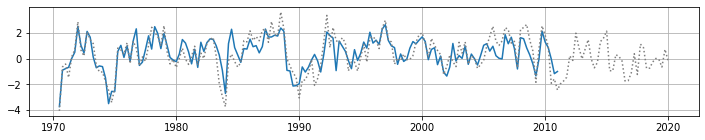

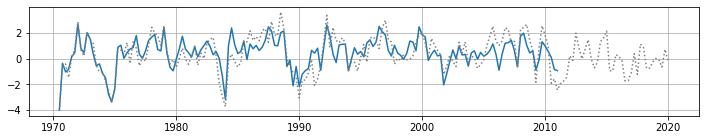

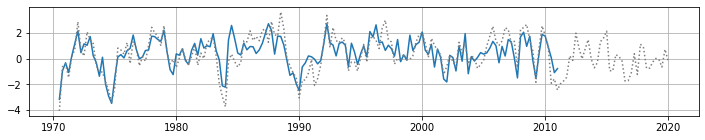

In [20]:
for i in range(3):
    plt.figure(figsize=(12, 2))
    plt.plot(nfit['fits'][i]['mf_Y_fit'][0], label=('A_fit('+str(i)+')'))
    #plt.plot(data_fit_best, linestyle='dashed')  
    plt.plot(Y_0[1:], color='C7', linestyle='dotted')
    plt.grid()
    plt.show()

Nowcast:

In [21]:
from LibESN.base_utils import *

# pd_to_np_array(None)
# pd_data_prep([np.array([1,2,3]), None])

In [22]:
from LibESN.mfesn_forecast import mfNowcast

# make examplary data
mfdata_test_now_1 = (
    Y_m0.loc["2011-01-01":"2011-03-01"], 
        Y_q0.loc["2011-01-01":"2011-03-01"]
)

mfdata_test_now_2 = (
    Y_m0.loc["2011-01-01":"2011-05-01"], 
        Y_q0.loc["2011-01-01":"2011-05-01"]
)

mfdata_test_now_3 = (
    Y_m0.loc["2011-01-01":], 
        Y_q0.loc["2011-01-01":]
)

In [23]:
now_1 = mfNowcast(
   mfmodel=mfesn,
   nowcast_data=mfdata_test_now_1,
   fit=fit,
   freqs=['M', 'Q-DEC']
)

In [24]:
now_2 = mfNowcast(
   mfmodel=mfesn,
   nowcast_data=mfdata_test_now_2,
   fit=fit,
   freqs=['M', 'Q-DEC'],
   terminal=False,
)

In [25]:
now_3 = mfNowcast(
   mfmodel=mfesn,
   nowcast_data=mfdata_test_now_3,
   fit=fit,
   freqs=['M', 'Q-DEC'],
   terminal=False,
)

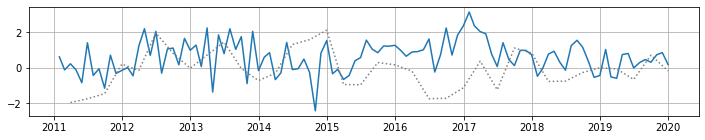

In [26]:
plt.figure(figsize=(12, 2))
plt.plot(now_3['nowcast'], label=('nowcast'))
#plt.plot(data_fit_best, linestyle='dashed')  
plt.plot(mfdata_test[1], color='C7', linestyle='dotted', label='data')
plt.grid()
plt.show()